In [135]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, default_collate
from datasets import load_dataset
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torch.optim import lr_scheduler

In [136]:
name = 'fashion_mnist'
x,y = 'image','label'
dsr = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00, 76.57it/s]


In [137]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'mps'

In [153]:
def transform(b):
    b[x] = [F.pad(TF.to_tensor(ele), (2,2,2,2)) for ele in b[x]]
    return b

def collate_fn(b):
    clt = default_collate(b)
    return (clt[x], clt[y])

class DataLoaders:
    def __init__(self, train_ds, val_ds, bs, collate_fn):
        self.train = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)
        self.valid = DataLoader(val_ds, batch_size=bs*2, shuffle=False, collate_fn=collate_fn)

In [154]:
bs = 128
dst = dsr.with_transform(transform)
dls = DataLoaders(dst['train'], dst['test'], bs=bs, collate_fn=collate_fn)

In [155]:
xb,yb = next(iter(dls.train))
xb.shape,yb.shape,xb.min(),xb.max()

(torch.Size([128, 1, 32, 32]), torch.Size([128]), tensor(0.), tensor(1.))

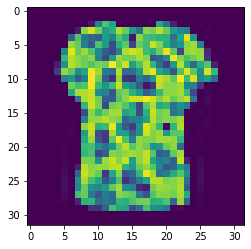

In [156]:
plt.imshow(xb[0].permute(1,2,0));

In [157]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
sigma = beta.sqrt()
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)

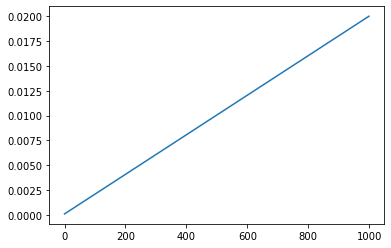

In [158]:
plt.plot(beta);

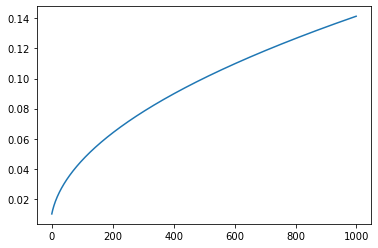

In [159]:
plt.plot(sigma);

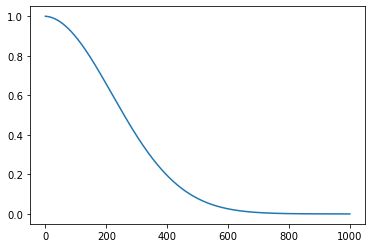

In [160]:
plt.plot(alphabar);

In [161]:
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    eps = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt()*eps
    return (xt, t.to(device)), eps

In [162]:
(xt, t), eps = noisify(xb[:25], alphabar)

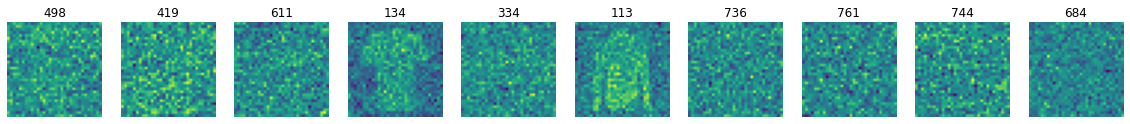

In [163]:
sz = 10
_,axs = plt.subplots(1, 10, figsize=(20, 5))
for im,ax,title in zip(xt[:sz], axs.flat, t[:sz]):
    ax.imshow(im.permute(1,2,0))
    ax.set_title(title.item())
    ax.set_axis_off()

In [177]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t >0 else torch.zeros(x_t.shape)).to(device)
        alphabar_t1 = alphabar[t-1] if t>0 else torch.tensor(1)
        betabar_t = 1-alphabar[t]
        betabar_t1 = 1-alphabar_t1
        x0_hat = ((x_t - betabar_t.sqrt()*model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1, 1)
        x_t = x0_hat * alphabar_t1.sqrt()*(1-alpha[t])/betabar_t + x_t * alpha[t].sqrt()*betabar_t1/betabar_t + sigma[t]*z
    return x_t

In [165]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [ ]:
lr = 5e-3
epochs = 5
tmax = epochs*len(dls.train)
model = UNet(in_channels=1, out_channels=1,\
              block_out_channels=(16, 32, 64, 64), norm_num_groups=8)
model = model.to(device)
opt = optim.AdamW(model.parameters(), lr=lr)
total_steps = epochs*len(dls.train)
sched = lr_scheduler.OneCycleLR(opt, max_lr=lr, total_steps=total_steps)
for epoch in range(epochs):
    dl = dls.train
    for xb,yb in dl:
      xb = xb.to(device)
      batch = noisify(xb, alphabar)
      preds = model(batch[0])
      loss = F.mse_loss(preds, batch[1])
      loss.backward()
      opt.step()
      opt.zero_grad()
      sched.step()
    print(f'epoch:{epoch}, loss:{loss.item():.3f}')

In [179]:
samples = sample(model, (10, 1, 32, 32), alpha, alphabar, sigma, n_steps)

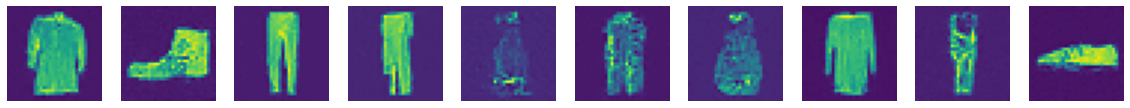

In [194]:
sz = 10
_,axs = plt.subplots(1, sz, figsize=(20, 20))
for im,ax in zip(samples.detach().cpu(), axs.flat):
    ax.imshow(im.permute(1,2,0))
    ax.set_axis_off()

In [ ]:
xb[:25].shape

torch.Size([25, 1, 28, 28])

In [167]:
torch.save(model.state_dict(), 'model.pth')